# IDS Assignment 5 – Computer Vision

To work in this Colab notebook, first save a copy of it via "File" -> "Save a copy in Drive" in the top-left menu bar.


### 1. Install all missing packages that we need an download our custom FashionMNIST data

The data files will be available locally in your Colab runtime. You can find them through the files menu on the left.

In [1]:
# Install packages
!pip install torchmetrics gdown

# Download training, validation, and test splits
!gdown https://drive.google.com/uc?id=1zYfBlExr_LK-Ld8rmxCTqRU5RAOUVVfh
!gdown https://drive.google.com/uc?id=1PJa_I3qG0P5whuARV_Se1_YUvHzR469R
!gdown https://drive.google.com/uc?id=1pC8-ummMGy1dPhHGPuNsms5_I7HpWgv2

  Using cached torchmetrics-1.3.2-py3-none-any.whl (841 kB)
  Using cached lightning_utilities-0.11.2-py3-none-any.whl (26 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 1.1 MB/s eta 0:00:00
     ━━━

### 2. Import classes and functions we will be using

In [2]:
import math
import os
import random
from typing import Any, Callable, Optional, Tuple

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.optim.lr_scheduler import LinearLR
from torch.utils.data import DataLoader
from torchvision.datasets import VisionDataset
from torchvision.transforms import Compose, Lambda, ToTensor
from torchvision.models.resnet import ResNet, BasicBlock
from torchmetrics.functional.classification import multiclass_confusion_matrix

### 3. Check which PyTorch version we are running and confirm that we are in a GPU runtime.
If this output shows that you are not in a GPU runtime, go to "Runtime" in the top-left menu bar -> "Change runtime type" -> set "Hardware Accelerator: GPU".

In [3]:
print(f"Running PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
!nvidia-smi

Running PyTorch version: 2.2.1+cu121
CUDA available: True
Thu Mar 28 17:19:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+---------

### 4. Make things (more) reproducible by setting random seeds

See here for details: https://pytorch.org/docs/stable/notes/randomness.html

In [4]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

### 5. Define our custom IDS FashionMNIST PyTorch dataset

Our model inherits, i.e. is a specific kind of, `VisionDataset` in torchvision.\
This means it has all features defined in `VisionDataset`, unless they are explicitly overridden here, \
plus any additional functionality that may be defined below. You can read more about `VisionDataset` here: https://pytorch.org/vision/main/generated/torchvision.datasets.VisionDataset.html.

In [5]:
class IDSFashionMnistDataset(VisionDataset):
    """
    FashionMNIST dataset for the IDS course which loads custom data files from disk
    """

    classes = [
        "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
        "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
    ]

    def __init__(
        self,
        root: str,
        split: str = "training",
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
    ) -> None:
        super().__init__(root, transform=transform, target_transform=target_transform)

        if not split in ["training", "validation", "test"]:
            raise ValueError("Split should be 'training', 'validation', or 'test'.")

        self.split = split
        self.root = root

        self.data, self.targets = self._load_data()

    def _load_data(self):
        data = torch.load(os.path.join(self.root, f"fashion_mnist_{self.split}.pt"))
        images = data[:, :-1].reshape(-1, 28, 28)  # 28x28 resolution
        labels = data[:, -1]
        return images, labels

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], int(self.targets[index])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode="L")

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)

### 6. Define our custom ResNet-18 model for FashionMNIST
The original ResNet-18 uses 3-channel (RGB) inputs and has 1000 output classes based on ImageNet-1K.

https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html

We instead use single-channel inputs (Grayscale) and 10 output classes according to FashionMNIST.

In [6]:
class FashionMnistResNet18(ResNet):
    """
    Custom ResNet-18 model which uses 1 input channel (grayscale) and has 10 output classes
    """
    def __init__(self):
        super().__init__(BasicBlock, [2,2,2,2,2], num_classes=10)
        self.conv1 = nn.Conv2d(1, 64,
          kernel_size=(7, 7),
          stride=(2, 2),
          padding=(3, 3),
          bias=False
        )

### 7. Load our custom FashionMNIST data

Here, we load our data using the `IDSFashionMnistDataset` class defined above. We also make use of the functionality in torchvision's `VisionDataset`, which `IDSFashionMnistDataset` inherits from, to set the transformations we want to apply when retrieving examples from our dataset. We use the `transform` keyword argument for this and compose our transformations using torchvision's `Compose` (https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html). In our base setting, the only transformation we apply is `ToTensor`, which converts our `PIL.Image` inputs into PyTorch tensors.

In [7]:
# Create base transformation for our dataset
# TODO: how can these be modified to randomly flip examples?
base_transform = Compose([
    ToTensor(),
])

# Load datasets
train_dataset = IDSFashionMnistDataset(".", "training", transform=base_transform)
validation_dataset = IDSFashionMnistDataset(".", "validation", transform=base_transform)
test_dataset = IDSFashionMnistDataset(".", "test", transform=base_transform)

# Check the sizes of our datasets
print(f"Training dataset length = {len(train_dataset)}")
print(f"Validation dataset length = {len(validation_dataset)}")
print(f"Test dataset length = {len(test_dataset)}")

Training dataset length = 5000
Validation dataset length = 1000
Test dataset length = 1000


### 8. Implement our evaluation function and training loop

Below, we provide some rudimentary functionality for training and evaluation,\
as well as metric storing and logging, for our experiments.

In [8]:
def log_metrics(metrics: dict, step: Optional[int] = None):
    """
    Log metrics stored in a dictionary
    """

    # During training, it can be useful to also log the current step
    if step is not None:
        print(f"\nMetrics step {step}:")

    for k, v in metrics.items():
        # We ignore the confusion matrix when logging metrics
        if not k.endswith("conf_matrix"):
            print(f"  {k}: {v}")

def evaluate(model, eval_dataloader, prefix="eval"):
    """
    Evaluation function that computes the loss, accuracy, and confusion matrix for the dataset
    passed via the `eval_dataloader` argument
    """

    # Define loss function
    criterion = nn.CrossEntropyLoss()

    # Move model to GPU
    model.cuda()

    # Set model to evaluation mode (e.g. to disable dropout)
    model.eval()

    eval_loss = 0
    y_pred = None
    y_true = None
    num_classes = None

    for batch_idx, batch in enumerate(tqdm(eval_dataloader, desc=f"Evaluating")):
        # Loop over batches in dataloader

        # Move batch to GPU
        inputs, labels = batch
        inputs = inputs.cuda()
        labels = labels.cuda()

        # Use no_grad mode to disable gradient computation
        with torch.no_grad():
            # Get model outputs
            outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)
        eval_loss += loss.detach().cpu().item()

        if num_classes is None:
            num_classes = len(outputs[0])

        # Get class predictions
        preds = torch.argmax(outputs, dim=-1)

        # Accumulate predictions and true classes over batches
        y_pred = torch.cat([y_pred, preds]) if y_pred is not None else preds
        y_true = torch.cat([y_true, labels]) if y_true is not None else labels


    # Move predictions and true classes back to CPU
    y_pred = y_pred.detach().cpu()
    y_true = y_true.detach().cpu()

    # Compute metrics
    eval_loss /= len(eval_dataloader)
    eval_acc = (y_pred == y_true).sum() / len(y_true)
    eval_conf_matrix = multiclass_confusion_matrix(
        y_pred, y_true, num_classes=num_classes
    )

    # Store metrics in a dictionary
    metrics = {
        f"{prefix}_loss": eval_loss,
        f"{prefix}_accuracy": eval_acc.item(),
        f"{prefix}_conf_matrix": eval_conf_matrix.numpy()
    }

    return metrics


def save_best_model(model: nn.Module):
  """
  Simple function that saves the weights of the specified model to disk.
  We use this to keep track of the best model (based on validation loss).
  """
  output_path = "best_model.pt"
  torch.save(model.state_dict(), output_path)
  print(f"Saved new best model to {output_path}\n")


def load_best_model(model: nn.Module, model_path: str = "best_model.pt"):
  """
  Simple function that loads model weights stored at `model_path` into the
  passed model of type `nn.Module`. We use this to load our best model checkpoint.
  """
  model.load_state_dict(torch.load(model_path))
  model.eval()
  print(f"Loaded best {model.__class__.__name__} model from {model_path}\n")
  return model


def train(
  model: nn.Module,
  train_dataloader: DataLoader,
  eval_dataloader: DataLoader,
  num_epochs: int = 20,
  lr: float = 0.1,
  eval_steps: int = 100
):
    """
    Training loop
    """

    # Create SGD optimizer with specified learning rate and fixed momentum
    optimizer = SGD(model.parameters(), lr=lr, momentum=0.9)

    # Create linear learning rate decay schedule
    scheduler = LinearLR(
        optimizer,
        start_factor=1.0,
        end_factor=1e-6,
        total_iters=len(train_dataloader) * num_epochs
    )

    # Define loss function
    criterion = nn.CrossEntropyLoss()

    # Move model to GPU
    model.cuda()

    total_loss = 0
    total_eval_loss = 0
    global_step = 0
    global_eval_step = 0
    best_eval_loss = float("inf")

    # Store our initial model
    save_best_model(model)

    # Create dictionary to store metrics throughout training
    metrics_dict = {}

    print("Starting model training")

    for epoch_idx in range(num_epochs):
        # Epoch loop (one epoch is one pass over the full training dataset)

        for batch_idx, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch_idx+1}")):
            # Loop over batches in training dataset

            # Set model to training mode
            model.train()

            global_step += 1

            # Move batch to GPU
            inputs, labels = batch
            inputs = inputs.cuda()
            labels = labels.cuda()

            # Get model outputs
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)
            total_loss += loss.detach().cpu().item()

            # Evaluation loop
            if global_step % eval_steps == 0:
                global_eval_step += 1
                metrics = {
                    "mean_train_loss": total_loss / global_step,
                    "learning_rate": scheduler.get_last_lr()[0]
                }

                # Evaluate on validation and training datasets
                metrics.update(evaluate(model, eval_dataloader, prefix="eval"))
                metrics.update(evaluate(model, train_dataloader, prefix="train"))

                # Update and log metrics
                total_eval_loss += metrics["eval_loss"]
                metrics["mean_eval_loss"] = total_eval_loss / global_eval_step
                log_metrics(metrics, step=global_step)
                metrics_dict[global_step] = metrics

                # Check if our validation loss has decreased, and if so,
                # update our best model checkpoint
                if metrics["eval_loss"] <= best_eval_loss:
                  best_eval_loss = metrics["eval_loss"]
                  save_best_model(model)

            # Compute gradients
            loss.backward()

            # Perform update step
            optimizer.step()

            # Reduce learning rate for stability
            scheduler.step()

            # Set gradients to zero
            model.zero_grad()

    return metrics_dict

### 9. Define hyperparameters, create dataloaders, instantiate model, and run training/evaluation procedure

Here, we set our hyper-parameters for the dataloader (batch size) and the training loop \
(number of epochs, learning rate, and evaluation interval in steps).

We only use very basic data loading functionality. More information on available features can be found here https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader.

In [9]:
# TODO: set your hyperparameters
bs = 256
num_epochs = 100
lr = 0.1
eval_steps = 100

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=bs, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

# Instantiate a new model
model = FashionMnistResNet18()

# Train model and save training and evaluation metrics
metrics_dict = train(
    model, train_dataloader, validation_dataloader, num_epochs=num_epochs, lr=lr, eval_steps=eval_steps
)

Saved new best model to best_model.pt

Starting model training


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 11.11it/s]

Evaluating: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]



Metrics step 100:
  mean_train_loss: 0.8788733670115471
  learning_rate: 0.09505000494999999
  eval_loss: 0.5320053547620773
  eval_accuracy: 0.7950000166893005
  train_loss: 0.44711886197328565
  train_accuracy: 0.8295999765396118
  mean_eval_loss: 0.5320053547620773


Epoch 5: 100%|██████████| 20/20 [00:05<00:00,  3.86it/s]


Saved new best model to best_model.pt



Evaluating: 100%|██████████| 4/4 [00:00<00:00, 30.16it/s]

Epoch 10: 100%|██████████| 20/20 [00:02<00:00,  8.66it/s]



Metrics step 200:
  mean_train_loss: 0.61699538230896
  learning_rate: 0.09005000994999993
  eval_loss: 0.4862157255411148
  eval_accuracy: 0.8379999995231628
  train_loss: 0.2544621527194977
  train_accuracy: 0.9034000039100647
  mean_eval_loss: 0.5091105401515961
Saved new best model to best_model.pt



Evaluating: 100%|██████████| 4/4 [00:00<00:00, 26.62it/s]

Epoch 15: 100%|██████████| 20/20 [00:02<00:00,  9.05it/s]



Metrics step 300:
  mean_train_loss: 0.48417041808366773
  learning_rate: 0.08505001494999989
  eval_loss: 0.5576807633042336
  eval_accuracy: 0.8360000252723694
  train_loss: 0.1465585980564356
  train_accuracy: 0.9455999732017517
  mean_eval_loss: 0.5253006145358086


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 26.38it/s]

Epoch 20: 100%|██████████| 20/20 [00:02<00:00,  7.97it/s]



Metrics step 400:
  mean_train_loss: 0.39814330663532016
  learning_rate: 0.08005001994999977
  eval_loss: 0.6847636923193932
  eval_accuracy: 0.8500000238418579
  train_loss: 0.1547524079680443
  train_accuracy: 0.9477999806404114
  mean_eval_loss: 0.5651663839817047


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 28.78it/s]

Epoch 25: 100%|██████████| 20/20 [00:02<00:00,  8.90it/s]



Metrics step 500:
  mean_train_loss: 0.33571726312488315
  learning_rate: 0.07505002494999956
  eval_loss: 0.8520045727491379
  eval_accuracy: 0.8349999785423279
  train_loss: 0.07368993815034627
  train_accuracy: 0.97079998254776
  mean_eval_loss: 0.6225340217351913


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 12.49it/s]

Epoch 30: 100%|██████████| 20/20 [00:03<00:00,  6.31it/s]



Metrics step 600:
  mean_train_loss: 0.2875929306385418
  learning_rate: 0.07005002994999944
  eval_loss: 0.8034123331308365
  eval_accuracy: 0.847000002861023
  train_loss: 0.030135322269052266
  train_accuracy: 0.9890000224113464
  mean_eval_loss: 0.6526804069677988


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 16.06it/s]

Epoch 35: 100%|██████████| 20/20 [00:02<00:00,  8.03it/s]



Metrics step 700:
  mean_train_loss: 0.24921403876406006
  learning_rate: 0.06505003494999935
  eval_loss: 0.9830322861671448
  eval_accuracy: 0.8410000205039978
  train_loss: 0.06585393389686942
  train_accuracy: 0.9778000116348267
  mean_eval_loss: 0.6998735325677055


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 28.90it/s]

Epoch 40: 100%|██████████| 20/20 [00:02<00:00,  8.87it/s]



Metrics step 800:
  mean_train_loss: 0.22051296433171955
  learning_rate: 0.06005003994999934
  eval_loss: 1.0476730912923813
  eval_accuracy: 0.8569999933242798
  train_loss: 0.0122539255884476
  train_accuracy: 0.9962000250816345
  mean_eval_loss: 0.7433484774082899


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 27.32it/s]

Epoch 45: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]



Metrics step 900:
  mean_train_loss: 0.19632413880293217
  learning_rate: 0.055050044949999356
  eval_loss: 1.077042281627655
  eval_accuracy: 0.8669999837875366
  train_loss: 0.0005295406095683575
  train_accuracy: 1.0
  mean_eval_loss: 0.7804255667659972


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 17.02it/s]

Epoch 50: 100%|██████████| 20/20 [00:02<00:00,  8.11it/s]



Metrics step 1000:
  mean_train_loss: 0.17677460269760922
  learning_rate: 0.050050049949999446
  eval_loss: 1.12192040681839
  eval_accuracy: 0.8709999918937683
  train_loss: 0.00012187913926027249
  train_accuracy: 1.0
  mean_eval_loss: 0.8145750507712364


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 28.17it/s]

Epoch 55: 100%|██████████| 20/20 [00:02<00:00,  8.58it/s]



Metrics step 1100:
  mean_train_loss: 0.16072376397292829
  learning_rate: 0.045050054949999536
  eval_loss: 1.1222764253616333
  eval_accuracy: 0.8610000014305115
  train_loss: 8.674133550812257e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.842547903006727


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 29.48it/s]

Epoch 60: 100%|██████████| 20/20 [00:02<00:00,  7.74it/s]



Metrics step 1200:
  mean_train_loss: 0.1473429160192821
  learning_rate: 0.04005005994999966
  eval_loss: 1.1537262946367264
  eval_accuracy: 0.8629999756813049
  train_loss: 6.542224982695189e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.8684794356425604


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 26.79it/s]

Epoch 65: 100%|██████████| 20/20 [00:02<00:00,  8.45it/s]



Metrics step 1300:
  mean_train_loss: 0.1360191204633716
  learning_rate: 0.03505006494999977
  eval_loss: 1.1706415563821793
  eval_accuracy: 0.8629999756813049
  train_loss: 5.4759081831434744e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.8917226756994541


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 28.24it/s]

Epoch 70: 100%|██████████| 20/20 [00:02<00:00,  7.74it/s]



Metrics step 1400:
  mean_train_loss: 0.1263113163125971
  learning_rate: 0.030050069949999845
  eval_loss: 1.1693153530359268
  eval_accuracy: 0.8659999966621399
  train_loss: 4.676384814956691e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.9115507240806308


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 28.76it/s]

Epoch 75: 100%|██████████| 20/20 [00:02<00:00,  7.39it/s]



Metrics step 1500:
  mean_train_loss: 0.11789728275358236
  learning_rate: 0.025050074949999862
  eval_loss: 1.1847822219133377
  eval_accuracy: 0.8659999966621399
  train_loss: 4.0952842391561715e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.9297661572694779


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 28.08it/s]

Epoch 80: 100%|██████████| 20/20 [00:02<00:00,  8.13it/s]



Metrics step 1600:
  mean_train_loss: 0.11053653197639506
  learning_rate: 0.02005007994999987
  eval_loss: 1.1841644048690796
  eval_accuracy: 0.8629999756813049
  train_loss: 4.575894463414443e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.945666047744453


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 18.97it/s]

Epoch 85: 100%|██████████| 20/20 [00:02<00:00,  7.81it/s]



Metrics step 1700:
  mean_train_loss: 0.10404168476358096
  learning_rate: 0.015050084949999864
  eval_loss: 1.1663628369569778
  eval_accuracy: 0.8650000095367432
  train_loss: 4.4530126615427434e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.958648211815778


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 27.52it/s]

Epoch 90: 100%|██████████| 20/20 [00:02<00:00,  8.21it/s]



Metrics step 1800:
  mean_train_loss: 0.09826714030257588
  learning_rate: 0.010050089949999917
  eval_loss: 1.1739370226860046
  eval_accuracy: 0.8619999885559082
  train_loss: 4.0962987986858936e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.9706087013085684


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 27.32it/s]

Epoch 95: 100%|██████████| 20/20 [00:02<00:00,  8.30it/s]



Metrics step 1900:
  mean_train_loss: 0.09309977912014705
  learning_rate: 0.005050094949999962
  eval_loss: 1.173462450504303
  eval_accuracy: 0.8629999756813049
  train_loss: 3.986045703641139e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.9812852144241333


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 25.34it/s]

Epoch 100: 100%|██████████| 20/20 [00:02<00:00,  8.27it/s]


Metrics step 2000:
  mean_train_loss: 0.0884499362166971
  learning_rate: 5.009994999999962e-05
  eval_loss: 1.186280518770218
  eval_accuracy: 0.8610000014305115
  train_loss: 3.860006745526334e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.9915349796414376


### 10. Load our saved best model checkpoint

We can make use of the `load_best_model` function defined above to quickly load \
the best model checkpoint for further evaluation.

You can find more information on saving and loading model weights at

https://pytorch.org/tutorials/beginner/saving_loading_models.html.

In [10]:
best_model = load_best_model(FashionMnistResNet18())

Loaded best FashionMnistResNet18 model from best_model.pt



### 11. Evaluate your best model and visualize the confusion matrix

TODO: You should implement this yourself using the functions defined above.

Evaluating: 100%|██████████| 4/4 [00:00<00:00, 10.81it/s]


0.8399999737739563


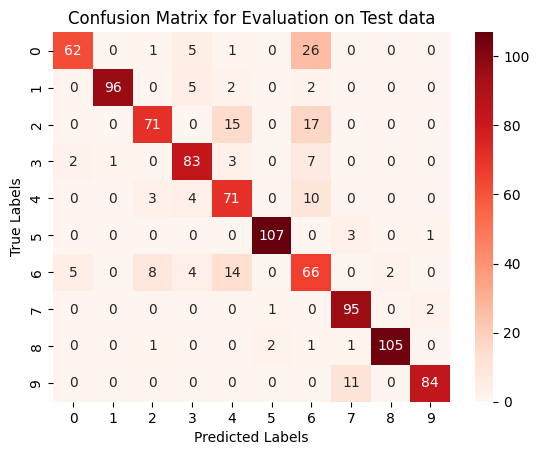

In [40]:

test_metric = evaluate(best_model, test_dataloader)

conf_matrix = test_metric["eval_conf_matrix"] # get confusion matrix
eval_loss = test_metric["eval_loss"] # get evaluation loss
eval_accuracy = test_metric["eval_accuracy"] # get evaluation accuracy

# get test accuracy of model at best validation loss:

learning_step, min_mean_eval_loss = min(metrics_dict.items(), key=lambda x: x[1]['mean_eval_loss']) # get minimum mean evaluation loss from training metric
test_accuracy = eval_accuracy # test accuracy at best validation loss 
print("Test accuracy: " + test_accuracy)
# visualize confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix for Evaluation on Test data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels') # echt???
plt.show()

#### Discussion of confusion matrix 



### 12. Plot your loss curves

TODO: You should implement this yourself. Use the `metrics_dict` returned by the training loop.

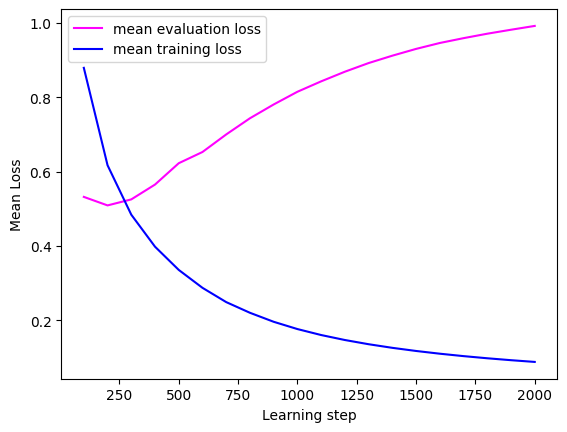

In [20]:
# TODO
training_steps = metrics_dict.keys()
mean_eval_loss = [metrics_dict[key]["mean_eval_loss"] for key in training_steps]
mean_train_loss = [metrics_dict[key]["mean_train_loss"] for key in training_steps]

sns.lineplot(x=training_steps, y=mean_eval_loss, color="magenta", label="mean evaluation loss")
sns.lineplot(x=training_steps, y=mean_train_loss, color="blue", label="mean training loss")
plt.title("Mean evaluation and training loss")
plt.xlabel("Learning Step")
plt.ylabel("Mean Loss")
plt.show()
# OVERFITTING

### 12. Plot your accuracy curves

TODO: You should implement this yourself. Use the `metrics_dict` returned by the training loop.

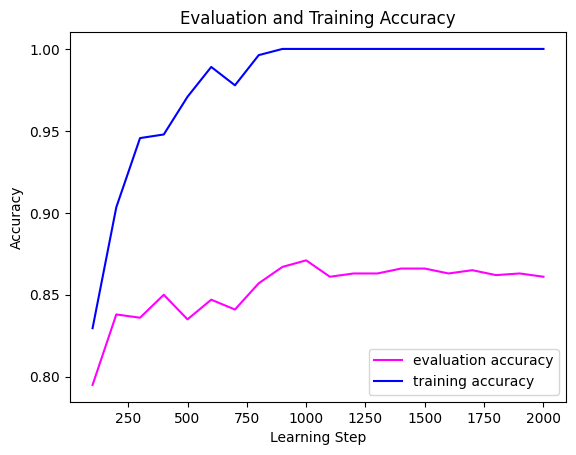

In [27]:
# TODO

training_steps = metrics_dict.keys()
eval_accuracy = [metrics_dict[key]["eval_accuracy"] for key in training_steps]
train_accuracy = [metrics_dict[key]["train_accuracy"] for key in training_steps]

sns.lineplot(x=training_steps, y=eval_accuracy, color="magenta", label="evaluation accuracy") # VALIDATION?
sns.lineplot(x=training_steps, y=train_accuracy, color="blue", label="training accuracy")
plt.title("Evaluation and Training Accuracy")
plt.xlabel("Learning Step")
plt.ylabel("Accuracy")
plt.show()

#### Descriptions of plots:

